**Downlaoding Dataset**

In [31]:
import kagglehub

# Download latest version
path = kagglehub.dataset_download("wordsforthewise/lending-club")

print("Path to dataset files:", path)

Using Colab cache for faster access to the 'lending-club' dataset.
Path to dataset files: /kaggle/input/lending-club


**Importing Dataset**

In [32]:
DATA_PATH = "/kaggle/input/lending-club/accepted_2007_to_2018q4.csv"


**Loading Dataset**

In [33]:
import kagglehub
import pandas as pd
import os

# Download latest version to ensure 'path' is defined
path = kagglehub.dataset_download("wordsforthewise/lending-club")

# Correct DATA_PATH to point to the actual CSV file inside the nested directory
DATA_PATH = os.path.join(path, "accepted_2007_to_2018q4.csv", "accepted_2007_to_2018Q4.csv")

use_cols = [
    "loan_amnt", "term", "int_rate", "grade", "sub_grade",
    "home_ownership", "annual_inc", "dti",
    "issue_d", "loan_status", "purpose"
]

df = pd.read_csv(
    DATA_PATH,
    usecols=use_cols,
    nrows=500_000,
    low_memory=False
)

print(df.shape)

Using Colab cache for faster access to the 'lending-club' dataset.
(500000, 11)


**Core Cleaning + Target Creation**

In [34]:
# Parse dates
df["issue_d"] = pd.to_datetime(df["issue_d"], errors="coerce")

# Keep completed loans only
df = df[df["loan_status"].isin(["Fully Paid", "Charged Off"])].copy()

# Create target variable
df["default"] = (df["loan_status"] == "Charged Off").astype(int)

# Fix numeric columns
df["int_rate"] = df["int_rate"].astype(str).str.rstrip('%').astype(float)
df["term"] = df["term"].astype(str).str.extract(r"(\d+)").astype(float)

# Drop invalid dates
df = df.dropna(subset=["issue_d"])

print(df.shape)
print("Default rate:", df["default"].mean())


/tmp/ipython-input-4174524350.py:2: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  df["issue_d"] = pd.to_datetime(df["issue_d"], errors="coerce")


(391164, 12)
Default rate: 0.20151138652841263


**Time-Based Train/Test Split**

In [35]:
print(df["issue_d"].min(), df["issue_d"].max())

split_date = "2017-01-01"

train_df = df[df["issue_d"] < split_date]
test_df  = df[df["issue_d"] >= split_date]

print("Train shape:", train_df.shape)
print("Test shape:", test_df.shape)


2015-01-01 00:00:00 2018-03-01 00:00:00
Train shape: (375545, 12)
Test shape: (15619, 12)


**Feature Definition**

In [36]:
target = "default"

num_features = ["loan_amnt", "int_rate", "term", "annual_inc", "dti"]
cat_features = ["grade", "sub_grade", "home_ownership", "purpose"]

X_train = train_df[num_features + cat_features]
y_train = train_df[target]

X_test  = test_df[num_features + cat_features]
y_test  = test_df[target]

print(X_train.shape, y_train.shape)
print(X_test.shape, y_test.shape)


(375545, 9) (375545,)
(15619, 9) (15619,)


**ML Pipeline**

In [37]:
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.impute import SimpleImputer
from sklearn.linear_model import LogisticRegression

numeric_transformer = Pipeline([
    ("imputer", SimpleImputer(strategy="median")),
    ("scaler", StandardScaler())
])

categorical_transformer = Pipeline([
    ("imputer", SimpleImputer(strategy="most_frequent")),
    ("onehot", OneHotEncoder(handle_unknown="ignore"))
])

preprocessor = ColumnTransformer([
    ("num", numeric_transformer, num_features),
    ("cat", categorical_transformer, cat_features)
])

log_reg = Pipeline([
    ("preprocessor", preprocessor),
    ("model", LogisticRegression(max_iter=1000))
])

log_reg.fit(X_train, y_train)


Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='median')),
                                                                  ('scaler',
                                                                   StandardScaler())]),
                                                  ['loan_amnt', 'int_rate',
                                                   'term', 'annual_inc',
                                                   'dti']),
                                                 ('cat',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('onehot',
                                                                   OneHotEncoder(handle_unknown='ignore'))]),
                                                  ['grade', 'sub_grade',
                                                   'home_ownership',
                                                   'purpose'])])),
                ('model', LogisticRegression(max_iter=1000))])

**Evaluation**

In [38]:
from sklearn.metrics import roc_auc_score

y_pred_proba = log_reg.predict_proba(X_test)[:, 1]
auc = roc_auc_score(y_test, y_pred_proba)

print("Logistic Regression AUC:", auc)


Logistic Regression AUC: 0.6922108294276414


**Train XGBoost Model**

In [39]:
from xgboost import XGBClassifier

xgb_model = Pipeline([
    ("preprocessor", preprocessor),
    ("model", XGBClassifier(
        n_estimators=300,
        max_depth=5,
        learning_rate=0.05,
        subsample=0.8,
        colsample_bytree=0.8,
        eval_metric="auc",
        random_state=42
    ))
])

xgb_model.fit(X_train, y_train)


Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='median')),
                                                                  ('scaler',
                                                                   StandardScaler())]),
                                                  ['loan_amnt', 'int_rate',
                                                   'term', 'annual_inc',
                                                   'dti']),
                                                 ('cat',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('onehot',
                                                                   OneHotEncoder(handle_unknown='ignore'))]),
                                                  ['grade',...
                               feature_types=None, feature_weights=None,
                               gamma=None, grow_policy=None,
                               importance_type=None,
                               interaction_constraints=None, learning_rate=0.05,
                               max_bin=None, max_cat_threshold=None,
                               max_cat_to_onehot=None, max_delta_step=None,
                               max_depth=5, max_leaves=None,
                               min_child_weight=None, missing=nan,
                               monotone_constraints=None, multi_strategy=None,
                               n_estimators=300, n_jobs=None,
                               num_parallel_tree=None, ...))])

**Evaluate XGBoost**

In [40]:
y_pred_proba_xgb = xgb_model.predict_proba(X_test)[:, 1]

from sklearn.metrics import roc_auc_score
auc_xgb = roc_auc_score(y_test, y_pred_proba_xgb)

print("XGBoost AUC:", auc_xgb)


XGBoost AUC: 0.6956948158676952


In [41]:
print("Logistic Regression AUC:", auc)
print("XGBoost AUC:", auc_xgb)


Logistic Regression AUC: 0.6922108294276414
XGBoost AUC: 0.6956948158676952


**Run SHAP**

In [47]:
import shap

# Extract trained components
xgb_fitted = xgb_model.named_steps["model"]
X_train_transformed = xgb_model.named_steps["preprocessor"].transform(X_train)

explainer = shap.TreeExplainer(xgb_fitted)
shap_values = explainer.shap_values(X_train_transformed)



**Global Explanation**

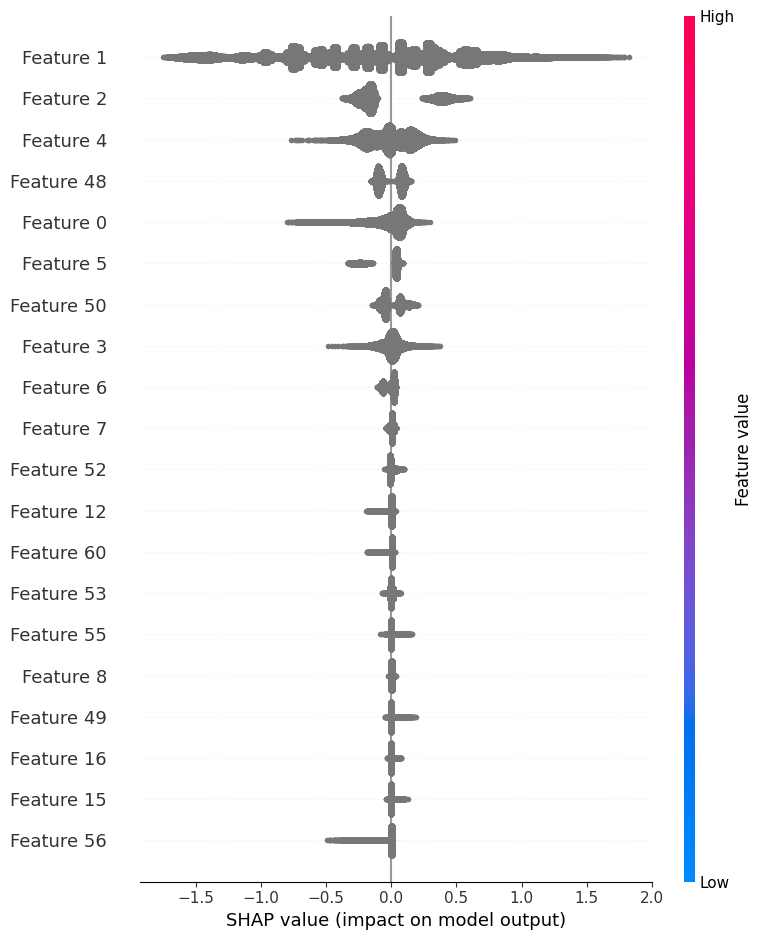

In [49]:
shap.summary_plot(shap_values, X_train_transformed)


In [50]:
X_train_dense = X_train_transformed.toarray()


In [51]:
shap_values_array = shap_values
if isinstance(shap_values, list):
    shap_values_array = shap_values[1]  # positive class (default)


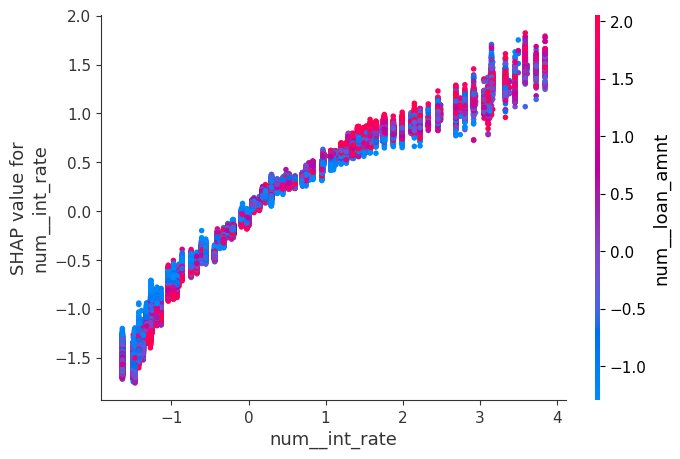

In [53]:
feature_names = xgb_model.named_steps["preprocessor"].get_feature_names_out()

shap.dependence_plot(
    "num__int_rate",
    shap_values_array,
    X_train_dense,
    feature_names=feature_names
)

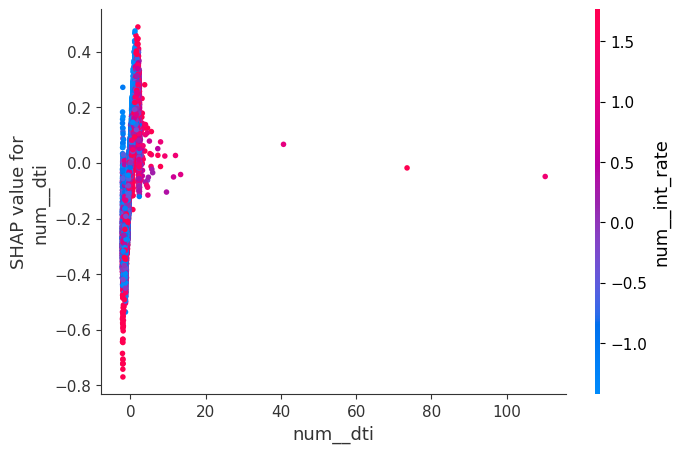

In [54]:
shap.dependence_plot(
    "num__dti",
    shap_values_array,
    X_train_dense,
    feature_names=feature_names
)


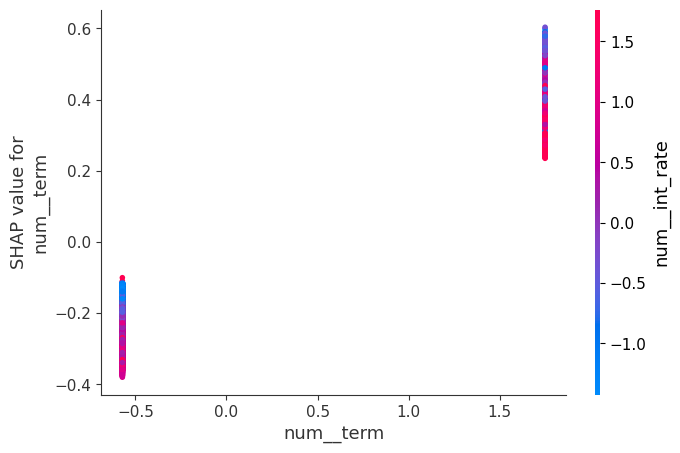

In [55]:
shap.dependence_plot(
    "num__term",
    shap_values_array,
    X_train_dense,
    feature_names=feature_names
)


# **DECISION INTELLIGENCE & POLICY SIMULATION**

**Create the Decision Dataset**

In [56]:
# Attach PD to test_df (if not already done)
test_df = test_df.copy()
test_df["pd"] = y_pred_proba_xgb

# PD-based Expected Loss
test_df["expected_loss"] = test_df["pd"] * test_df["loan_amnt"]

test_df[["pd", "loan_amnt", "expected_loss"]].head()


,pd,loan_amnt,expected_loss
421101,0.041957,3000.0,125.870124
421113,0.121328,5000.0,606.638081
421120,0.139962,7000.0,979.732558
421135,0.373726,30000.0,11211.767793
421137,0.387893,21000.0,8145.745307


**Define Credit Policy**

In [59]:
def credit_decision(pd):
    if pd < 0.10:
        return "Approve"
    elif pd < 0.25:
        return "Review"
    else:
        return "Reject"

test_df["decision"] = test_df["pd"].apply(credit_decision)


**Understanding the policy**

In [60]:
test_df["decision"].value_counts(normalize=True)


,proportion
decision,
Review,0.401818
Reject,0.314297
Approve,0.283885


In [61]:
decision_summary = test_df.groupby("decision").agg(
    customers=("pd", "count"),
    total_exposure=("loan_amnt", "sum"),
    expected_loss=("expected_loss", "sum"),
    avg_pd=("pd", "mean")
)

decision_summary


,customers,total_exposure,expected_loss,avg_pd
decision,,,,
Approve,4434,60798350.0,3.242253e+06,0.055924
Reject,4909,84767300.0,3.349829e+07,0.387998
Review,6276,92952325.0,1.589438e+07,0.167850


# **POLICY SIMULATION**

**Flexible Policy Simulator**

In [62]:
def simulate_policy(df, approve_thr, review_thr):
    def decide(pd):
        if pd < approve_thr:
            return "Approve"
        elif pd < review_thr:
            return "Review"
        else:
            return "Reject"

    temp = df.copy()
    temp["decision"] = temp["pd"].apply(decide)

    return temp.groupby("decision").agg(
        customers=("pd", "count"),
        total_exposure=("loan_amnt", "sum"),
        expected_loss=("expected_loss", "sum"),
        avg_pd=("pd", "mean")
    )


**Scenario 1 — Conservative Policy**

In [63]:
simulate_policy(test_df, approve_thr=0.08, review_thr=0.20)


,customers,total_exposure,expected_loss,avg_pd
decision,,,,
Approve,3488,48570375.0,2.142036e+06,0.046677
Reject,6633,112305850.0,3.967074e+07,0.345301
Review,5498,77641750.0,1.082214e+07,0.136938


**Scenario 2 — Balanced Policy**

In [64]:
simulate_policy(test_df, approve_thr=0.10, review_thr=0.25)


,customers,total_exposure,expected_loss,avg_pd
decision,,,,
Approve,4434,60798350.0,3.242253e+06,0.055924
Reject,4909,84767300.0,3.349829e+07,0.387998
Review,6276,92952325.0,1.589438e+07,0.167850


***🔍 Scenario 3 — Aggressive Growth Policy***

In [65]:
simulate_policy(test_df, approve_thr=0.15, review_thr=0.30)


,customers,total_exposure,expected_loss,avg_pd
decision,,,,
Approve,6972,95477275.0,7.582598e+06,0.080874
Reject,3593,63631250.0,2.773052e+07,0.430164
Review,5054,79409450.0,1.732181e+07,0.216987


# **Define a Simple Profit Model**

**Compute Expected Interest Income**

In [66]:
# Expected interest income approximation
test_df["expected_income"] = (
    test_df["loan_amnt"] * (test_df["int_rate"] / 100)
)


**Net Expected Profit**

In [68]:
test_df["expected_profit"] = (
    test_df["expected_income"] - test_df["expected_loss"]
)


# **Threshold Sweep**

**Create Threshold Evaluation Function**

In [69]:
import numpy as np

def evaluate_threshold(df, threshold):
    approved = df[df["pd"] < threshold]

    return {
        "threshold": threshold,
        "approval_rate": len(approved) / len(df),
        "total_exposure": approved["loan_amnt"].sum(),
        "expected_loss": approved["expected_loss"].sum(),
        "expected_income": approved["expected_income"].sum(),
        "expected_profit": approved["expected_profit"].sum(),
        "avg_pd": approved["pd"].mean()
    }


**Run Threshold Sweep**

In [70]:
thresholds = np.arange(0.05, 0.40, 0.01)

results = pd.DataFrame(
    [evaluate_threshold(test_df, t) for t in thresholds]
)

results.head()


,threshold,approval_rate,total_exposure,expected_loss,expected_income,expected_profit,avg_pd
0,0.05,0.123503,29463875.0,9.252446e+05,1.865357e+06,9.401126e+05,0.032899
1,0.06,0.162430,36914400.0,1.334796e+06,2.411538e+06,1.076743e+06,0.038154
2,0.07,0.195403,43254400.0,1.744404e+06,2.912629e+06,1.168225e+06,0.042647
3,0.08,0.223318,48570375.0,2.142036e+06,3.371380e+06,1.229344e+06,0.046677
4,0.09,0.253537,54611225.0,2.653181e+06,3.932910e+06,1.279729e+06,0.051232


## **Find the Optimal Policy**

**Profit vs Threshold**

In [71]:
results.sort_values("expected_profit", ascending=False).head(5)


,threshold,approval_rate,total_exposure,expected_loss,expected_income,expected_profit,avg_pd
5,0.10,0.283885,60798350.0,3.242253e+06,4.541379e+06,1.299126e+06,0.055924
4,0.09,0.253537,54611225.0,2.653181e+06,3.932910e+06,1.279729e+06,0.051232
6,0.11,0.316281,67142875.0,3.908611e+06,5.183882e+06,1.275271e+06,0.060961
3,0.08,0.223318,48570375.0,2.142036e+06,3.371380e+06,1.229344e+06,0.046677
7,0.12,0.350471,74539100.0,4.760562e+06,5.960844e+06,1.200282e+06,0.066235


# **Visualize the Trade-offs**

**Plot Curve**

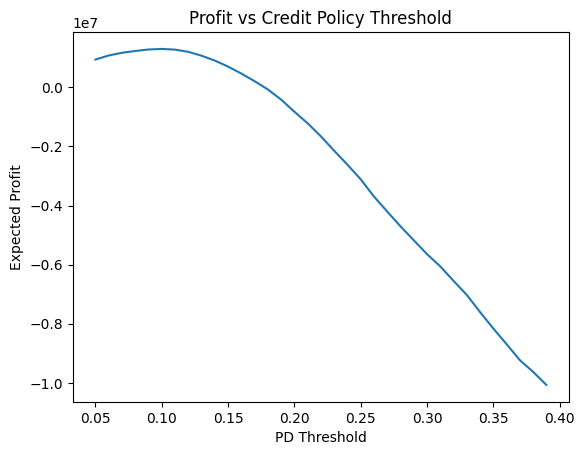

In [72]:
import matplotlib.pyplot as plt

plt.figure()
plt.plot(results["threshold"], results["expected_profit"])
plt.xlabel("PD Threshold")
plt.ylabel("Expected Profit")
plt.title("Profit vs Credit Policy Threshold")
plt.show()


**Risk vs Growth Curve**

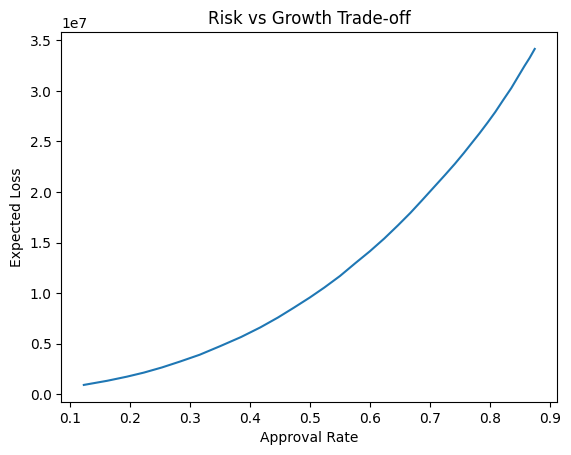

In [73]:
plt.figure()
plt.plot(results["approval_rate"], results["expected_loss"])
plt.xlabel("Approval Rate")
plt.ylabel("Expected Loss")
plt.title("Risk vs Growth Trade-off")
plt.show()


# **Create a Structured Explanation Context**

**Create explanation fields**

In [74]:
def build_explanation_context(row):
    return {
        "pd": round(row["pd"], 3),
        "expected_loss": round(row["expected_loss"], 2),
        "expected_income": round(row["expected_income"], 2),
        "expected_profit": round(row["expected_profit"], 2),
        "decision": row["decision"],
        "loan_amount": row["loan_amnt"],
        "interest_rate": round(row["int_rate"], 2),
        "term": int(row["term"]),
        "purpose": row["purpose"]
    }

example_context = build_explanation_context(test_df.iloc[0])
example_context


{'pd': np.float32(0.042),
 'expected_loss': np.float64(125.87),
 'expected_income': np.float64(220.2),
 'expected_profit': np.float64(94.33),
 'decision': 'Approve',
 'loan_amount': np.float64(3000.0),
 'interest_rate': np.float64(7.34),
 'term': 36,
 'purpose': 'major_purchase'}

# **LLM Prompt Template**

In [75]:
def credit_explanation_prompt(context):
    return f"""
You are an AI Credit Analyst.

Given the following loan assessment details, explain the credit decision in clear,
professional, non-technical language suitable for a business user.

Loan details:
- Loan amount: {context['loan_amount']}
- Interest rate: {context['interest_rate']}%
- Loan term: {context['term']} months
- Loan purpose: {context['purpose']}

Risk assessment:
- Predicted probability of default (PD): {context['pd']}
- Expected loss: {context['expected_loss']}
- Expected income: {context['expected_income']}
- Expected profit: {context['expected_profit']}

Final credit decision: {context['decision']}

Explain:
1. Why this decision was made
2. The main risk considerations
3. Whether the risk is acceptable or requires caution
"""


In [76]:
prompt = credit_explanation_prompt(example_context)

# response = llm(prompt)
# print(response)


In [77]:
sample_explanations = test_df.sample(5).copy()
sample_explanations["explanation_context"] = sample_explanations.apply(
    build_explanation_context, axis=1
)

sample_explanations["prompt"] = sample_explanations["explanation_context"].apply(
    credit_explanation_prompt
)

sample_explanations[["decision", "prompt"]]


,decision,prompt
458105,Review,\nYou are an AI Credit Analyst.\n\nGiven the f...
452523,Approve,\nYou are an AI Credit Analyst.\n\nGiven the f...
425936,Review,\nYou are an AI Credit Analyst.\n\nGiven the f...
479007,Approve,\nYou are an AI Credit Analyst.\n\nGiven the f...
470976,Review,\nYou are an AI Credit Analyst.\n\nGiven the f...


# **Batch Explanations**

In [78]:
sample_explanations = test_df.sample(5).copy()
sample_explanations["explanation_context"] = sample_explanations.apply(
    build_explanation_context, axis=1
)

sample_explanations["prompt"] = sample_explanations["explanation_context"].apply(
    credit_explanation_prompt
)

sample_explanations[["decision", "prompt"]]


,decision,prompt
469823,Approve,\nYou are an AI Credit Analyst.\n\nGiven the f...
469409,Reject,\nYou are an AI Credit Analyst.\n\nGiven the f...
498363,Approve,\nYou are an AI Credit Analyst.\n\nGiven the f...
498568,Review,\nYou are an AI Credit Analyst.\n\nGiven the f...
481075,Review,\nYou are an AI Credit Analyst.\n\nGiven the f...


# **AI Credit Decision Intelligence Dashboard (Streamlit)**

**Save model & preprocessor**

In [79]:
import joblib

joblib.dump(xgb_model, "xgb_model.pkl")
joblib.dump(preprocessor, "preprocessor.pkl")


['preprocessor.pkl']

**Save decision-ready data**

In [80]:
test_df.to_csv("test_df.csv", index=False)


**Streamlit App**

In [81]:
!pip install streamlit

import streamlit as st
import pandas as pd
import joblib

st.set_page_config(page_title="AI Credit Decision Intelligence", layout="wide")

# Load artifacts
model = joblib.load("xgb_model.pkl")
data = pd.read_csv("test_df.csv")

st.title("💳 AI Credit Decision Intelligence Dashboard")

# -------------------------------
# Sidebar – Policy Controls
# -------------------------------
st.sidebar.header("Credit Policy Controls")

approve_thr = st.sidebar.slider("Approve Threshold (PD)", 0.01, 0.30, 0.10)
review_thr = st.sidebar.slider("Review Threshold (PD)", 0.05, 0.50, 0.25)

# -------------------------------
# Decision Logic
# -------------------------------
def credit_decision(pd):
    if pd < approve_thr:
        return "Approve"
    elif pd < review_thr:
        return "Review"
    else:
        return "Reject"

data["decision"] = data["pd"].apply(credit_decision)

# -------------------------------
# Portfolio Metrics
# -------------------------------
col1, col2, col3, col4 = st.columns(4)

col1.metric("Total Loans", len(data))
col2.metric("Approval Rate", f"{(data['decision']=='Approve').mean():.2%}")
col3.metric("Expected Loss", f"${data['expected_loss'].sum():,.0f}")
col4.metric("Expected Profit", f"${data['expected_profit'].sum():,.0f}")

st.divider()

# -------------------------------
# Decision Distribution
# -------------------------------
st.subheader("📊 Decision Distribution")
st.bar_chart(data["decision"].value_counts())

# -------------------------------
# Individual Loan Analyzer
# -------------------------------
st.subheader("🔍 Individual Loan Analysis")

loan_idx = st.selectbox("Select Loan Index", data.index)

loan = data.loc[loan_idx]

st.write("### Loan Summary")
st.json({
    "PD": round(loan["pd"], 3),
    "Decision": loan["decision"],
    "Expected Loss": round(loan["expected_loss"], 2),
    "Expected Profit": round(loan["expected_profit"], 2),
    "Interest Rate": loan["int_rate"],
    "Loan Amount": loan["loan_amnt"]
})

st.write("### AI Explanation")
st.info(
    f"""
This loan was **{loan['decision']}** because the predicted default risk is {loan['pd']:.2%}.
The expected loss is {loan['expected_loss']:.2f}, compared to expected income of
{loan['expected_income']:.2f}. The risk level is consistent with the current credit policy.
"""
)

2026-01-06 17:14:51.714 WARNING streamlit.runtime.scriptrunner_utils.script_run_context: Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2026-01-06 17:14:51.797 WARNING streamlit.runtime.scriptrunner_utils.script_run_context: Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2026-01-06 17:14:51.993 
  command:

    streamlit run /usr/local/lib/python3.12/dist-packages/colab_kernel_launcher.py [ARGUMENTS]
2026-01-06 17:14:51.994 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2026-01-06 17:14:51.995 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2026-01-06 17:14:51.997 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2026-01-06 17:14:51.998 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when runn

DeltaGenerator()

In [82]:
!pip install streamlit pyngrok


In [83]:
%%writefile app.py
import streamlit as st

st.title("Streamlit Test App")
st.write("If you can see this, Streamlit is working 🎉")


Overwriting app.py


In [84]:
!streamlit run app.py &>/content/logs.txt &


In [85]:
from pyngrok import ngrok

# You need to provide your ngrok authtoken here.
# Get it from https://dashboard.ngrok.com/get-started/your-authtoken
# For example: !ngrok authtoken <YOUR_AUTHTOKEN>
# Or, set it directly in Python:
# ngrok.set_auth_token("YOUR_AUTH_TOKEN")

# For demonstration, I'll add a placeholder. Replace 'YOUR_AUTH_TOKEN' with your actual token.
# You can also set it using secrets in Colab for better security.
import getpass

# Try to get the auth token from Colab secrets if available
NGROK_AUTH_TOKEN = os.environ.get("NGROK_AUTH_TOKEN")

if not NGROK_AUTH_TOKEN:
    # If not in secrets, prompt the user
    print("Please enter your ngrok authtoken (get it from https://dashboard.ngrok.com/get-started/your-authtoken):")
    NGROK_AUTH_TOKEN = getpass.getpass()
    if not NGROK_AUTH_TOKEN:
        raise ValueError("ngrok authtoken not provided.")

ngrok.set_auth_token(NGROK_AUTH_TOKEN)

public_url = ngrok.connect(8501)
print(f"ngrok tunnel is active at: {public_url}")
public_url

Please enter your ngrok authtoken (get it from https://dashboard.ngrok.com/get-started/your-authtoken):
··········
ngrok tunnel is active at: NgrokTunnel: "https://unrent-flightier-lashon.ngrok-free.dev" -> "http://localhost:8501"


<NgrokTunnel: "https://unrent-flightier-lashon.ngrok-free.dev" -> "http://localhost:8501">

In [86]:
%%writefile app.py
import streamlit as st
import pandas as pd

st.set_page_config(page_title="Credit Decision Dashboard", layout="wide")

st.title("💳 AI Credit Decision Intelligence")

# Load decision-ready data
data = pd.read_csv("test_df.csv")

st.subheader("Dataset Preview")
st.dataframe(data.head())

st.success("If you can see this table, your project data is loading correctly ✅")


Overwriting app.py


In [87]:
!streamlit run app.py &>/content/logs.txt &


37t5LRn9J3qwy0OEFOIgKtWbYUW_3Az9ZGKEKe6Jo8HRNogqD

In [88]:
from pyngrok import ngrok
public_url = ngrok.connect(8501)
public_url


<NgrokTunnel: "https://unrent-flightier-lashon.ngrok-free.dev" -> "http://localhost:8501">

In [89]:
%%writefile app.py
import streamlit as st
import pandas as pd

st.set_page_config(page_title="Credit Decision Dashboard", layout="wide")

st.title("💳 AI Credit Decision Intelligence Dashboard")

# Load data
data = pd.read_csv("test_df.csv")

# -------------------------------
# Portfolio KPIs
# -------------------------------
st.subheader("📊 Portfolio Overview")

col1, col2, col3, col4 = st.columns(4)

col1.metric("Total Loans", len(data))
col2.metric(
    "Approval Rate",
    f"{(data['decision'] == 'Approve').mean():.2%}"
)
col3.metric(
    "Total Expected Loss",
    f"${data['expected_loss'].sum():,.0f}"
)
col4.metric(
    "Total Expected Profit",
    f"${data['expected_profit'].sum():,.0f}"
)

st.divider()

st.success("Portfolio KPIs loaded successfully ✅")


Overwriting app.py


In [90]:
!streamlit run app.py &>/content/logs.txt &


In [91]:
from pyngrok import ngrok
public_url = ngrok.connect(8501)
public_url


<NgrokTunnel: "https://unrent-flightier-lashon.ngrok-free.dev" -> "http://localhost:8501">

In [92]:
%%writefile app.py
import streamlit as st
import pandas as pd

st.set_page_config(page_title="Credit Decision Dashboard", layout="wide")

st.title("💳 AI Credit Decision Intelligence Dashboard")

# Load data
data = pd.read_csv("test_df.csv")

# -------------------------------
# Sidebar — Credit Policy Controls
# -------------------------------
st.sidebar.header("⚙️ Credit Policy Controls")

approve_thr = st.sidebar.slider(
    "Approve if PD <",
    min_value=0.01,
    max_value=0.30,
    value=0.10,
    step=0.01
)

review_thr = st.sidebar.slider(
    "Review if PD <",
    min_value=0.05,
    max_value=0.50,
    value=0.25,
    step=0.01
)

# Ensure logical order
if review_thr <= approve_thr:
    st.sidebar.error("Review threshold must be higher than approve threshold.")

# -------------------------------
# Decision Logic
# -------------------------------
def credit_decision(pd):
    if pd < approve_thr:
        return "Approve"
    elif pd < review_thr:
        return "Review"
    else:
        return "Reject"

data = data.copy()
data["decision"] = data["pd"].apply(credit_decision)

# -------------------------------
# Portfolio KPIs
# -------------------------------
st.subheader("📊 Portfolio Overview")

col1, col2, col3, col4 = st.columns(4)

col1.metric("Total Loans", len(data))
col2.metric(
    "Approval Rate",
    f"{(data['decision'] == 'Approve').mean():.2%}"
)
col3.metric(
    "Total Expected Loss",
    f"${data['expected_loss'].sum():,.0f}"
)
col4.metric(
    "Total Expected Profit",
    f"${data['expected_profit'].sum():,.0f}"
)

st.divider()

st.success("Credit policy applied dynamically ✅")


Overwriting app.py


In [93]:
!streamlit run app.py &>/content/logs.txt &


In [94]:
from pyngrok import ngrok
public_url = ngrok.connect(8501)
public_url


<NgrokTunnel: "https://unrent-flightier-lashon.ngrok-free.dev" -> "http://localhost:8501">

In [95]:
%%writefile app.py
import streamlit as st
import pandas as pd

st.set_page_config(page_title="Credit Decision Dashboard", layout="wide")

st.title("💳 AI Credit Decision Intelligence Dashboard")

# Load data
data = pd.read_csv("test_df.csv")

# -------------------------------
# Sidebar — Credit Policy Controls
# -------------------------------
st.sidebar.header("⚙️ Credit Policy Controls")

approve_thr = st.sidebar.slider(
    "Approve if PD <",
    min_value=0.01,
    max_value=0.30,
    value=0.10,
    step=0.01
)

review_thr = st.sidebar.slider(
    "Review if PD <",
    min_value=0.05,
    max_value=0.50,
    value=0.25,
    step=0.01
)

if review_thr <= approve_thr:
    st.sidebar.error("Review threshold must be higher than approve threshold.")

# -------------------------------
# Decision Logic
# -------------------------------
def credit_decision(pd):
    if pd < approve_thr:
        return "Approve"
    elif pd < review_thr:
        return "Review"
    else:
        return "Reject"

data = data.copy()
data["decision"] = data["pd"].apply(credit_decision)

# -------------------------------
# Portfolio KPIs
# -------------------------------
st.subheader("📊 Portfolio Overview")

col1, col2, col3, col4 = st.columns(4)

col1.metric("Total Loans", len(data))
col2.metric("Approval Rate", f"{(data['decision']=='Approve').mean():.2%}")
col3.metric("Total Expected Loss", f"${data['expected_loss'].sum():,.0f}")
col4.metric("Total Expected Profit", f"${data['expected_profit'].sum():,.0f}")

st.divider()

# -------------------------------
# Decision Distribution
# -------------------------------
st.subheader("📈 Decision Distribution")

decision_counts = data["decision"].value_counts()
st.bar_chart(decision_counts)

st.divider()

# -------------------------------
# Individual Loan Analyzer
# -------------------------------
st.subheader("🔍 Individual Loan Analysis")

loan_idx = st.selectbox("Select a Loan Index", data.index)

loan = data.loc[loan_idx]

st.markdown("### Loan Summary")

st.json({
    "Probability of Default (PD)": round(loan["pd"], 3),
    "Decision": loan["decision"],
    "Expected Loss": round(loan["expected_loss"], 2),
    "Expected Profit": round(loan["expected_profit"], 2),
    "Interest Rate (%)": loan["int_rate"],
    "Loan Amount": loan["loan_amnt"],
    "Loan Purpose": loan["purpose"]
})

st.markdown("### 🤖 AI Credit Explanation")

st.info(
    f"""
This loan was **{loan['decision']}** because the predicted probability of default
is **{loan['pd']:.2%}**.

Based on the current credit policy:
- The expected loss is **{loan['expected_loss']:.2f}**
- The expected profit is **{loan['expected_profit']:.2f}**

This risk level is {'acceptable' if loan['decision']=='Approve' else 'moderate and requires review' if loan['decision']=='Review' else 'high and exceeds the risk tolerance'} under the selected policy thresholds.
"""
)

st.success("Dashboard updated successfully ✅")


Overwriting app.py


In [96]:
!streamlit run app.py &>/content/logs.txt &


In [97]:
from pyngrok import ngrok
public_url = ngrok.connect(8501)
public_url


<NgrokTunnel: "https://unrent-flightier-lashon.ngrok-free.dev" -> "http://localhost:8501">